In [463]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import yfinance as yf
from datetime import timedelta, date, datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [464]:
# Retrieve stock data from Yahoo Finance

# stock_list = ['AAPL', 'TSLA', 'XOM', 'JPM']
stock_list = ['AAPL', 'TSLA']

# Date range is 50 days + 1 year + 1 month.
# 50 day start buffer is for 50-day EMA calculations.
# 1 month end buffer is for price prediction.
# Model will only be run on the 1 year data.
end_date_buffer = date(2023, 11, 26)
end_date = end_date_buffer - timedelta(days=31)
start_date = end_date - timedelta(days=365)
start_date_buffer = start_date - timedelta(days=50)

# Date to string
start = start_date.strftime('%Y-%m-%d')
end = end_date.strftime('%Y-%m-%d')

stock_dfs = []
for stock in stock_list:
    df = yf.Ticker(stock).history(start=start_date_buffer, end=end_date_buffer)
    # Only need closing price data
    stock_dfs.append(pd.DataFrame(df['Close']).rename(columns={'Close':'Price'})) 

    
for stock_df in stock_dfs:
    stock_df.index = stock_df.index.strftime('%Y-%m-%d')
    
    # Check for missing values
    print(stock_df.isnull().values.any()) 
    print(stock_df.shape)
    print(stock_df)

False
(308, 1)
                 Price
Date                  
2022-09-06  153.416550
2022-09-07  154.836243
2022-09-08  153.347076
2022-09-09  156.236084
2022-09-12  162.252411
...                ...
2023-11-17  189.690002
2023-11-20  191.449997
2023-11-21  190.639999
2023-11-22  191.309998
2023-11-24  189.970001

[308 rows x 1 columns]
False
(308, 1)
                 Price
Date                  
2022-09-06  274.420013
2022-09-07  283.700012
2022-09-08  289.260010
2022-09-09  299.679993
2022-09-12  304.420013
...                ...
2023-11-17  234.300003
2023-11-20  235.600006
2023-11-21  241.199997
2023-11-22  234.210007
2023-11-24  235.449997

[308 rows x 1 columns]


In [465]:
# Calculate momentum, volatility and EMAs (7, 20, and 50-day)

ma_day = [7, 20, 50]

for i, stock in enumerate(stock_list):
    stock_df = stock_dfs[i]
    stock_df['Momentum'] = np.where(stock_df['Price'] < stock_df['Price'].shift(1), 0, 1)
    stock_df['Volatility'] = (stock_df['Price'].shift(1)-stock_df['Price'])/stock_df['Price'].shift(1)
    for ma in ma_day:
        ema_column = '%sEMA' % ma
        stock_df[ema_column] = ( 
            stock_df[price_column].ewm(span=ma, adjust=False).mean()
        )
    
    # Calculations complete, the start buffer can be removed
    stock_df.drop(stock_df.loc[:start].index, inplace=True)
    print(stock_df.head(1))

                 Price  Momentum  Volatility        7EMA       20EMA  \
Date                                                                   
2022-10-27  143.756668         0    0.030465  145.826237  144.973547   

                50EMA  
Date                   
2022-10-27  147.38837  
                 Price  Momentum  Volatility        7EMA      20EMA  \
Date                                                                  
2022-10-27  225.089996         1   -0.002003  220.609182  230.17493   

                 50EMA  
Date                    
2022-10-27  250.121246  


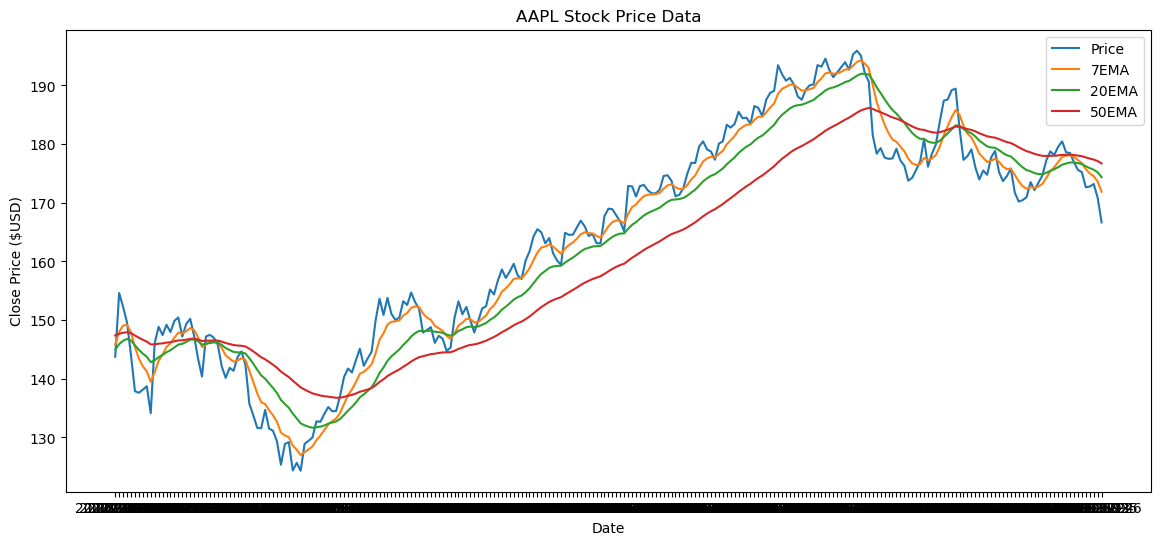

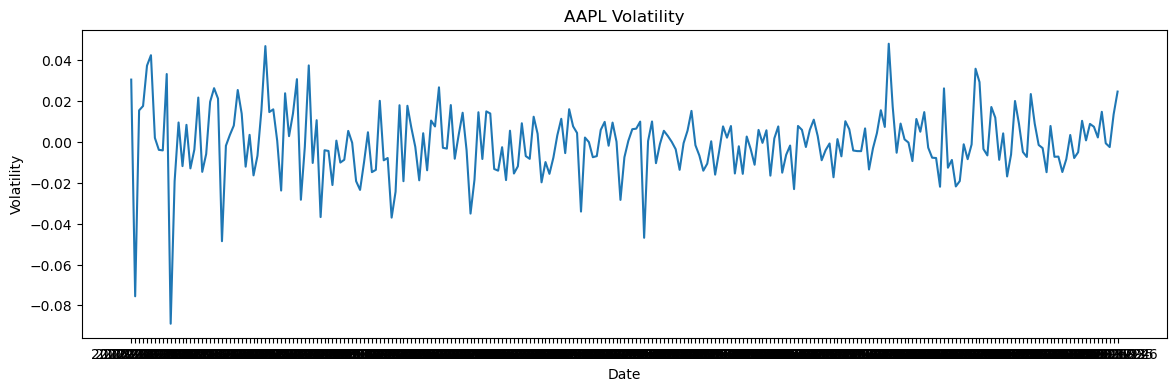

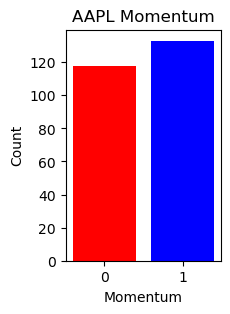

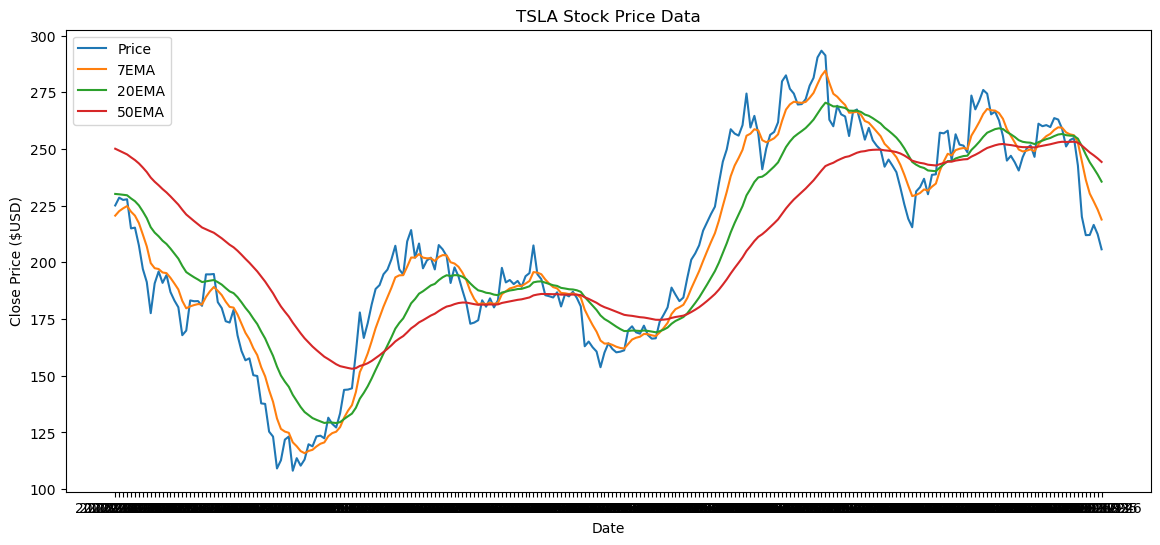

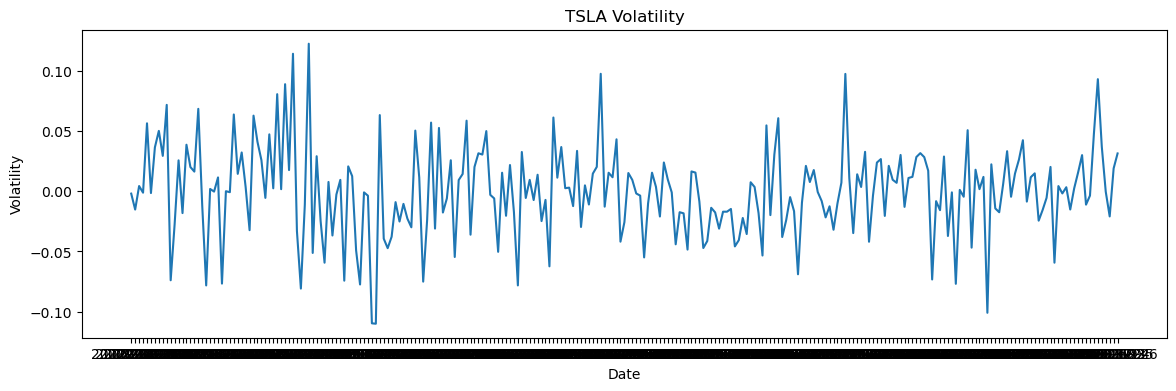

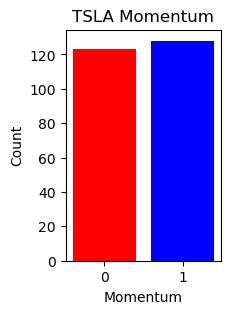

In [466]:
# Plot a year of data from all stock dataframes

for i, stock in enumerate(stock_list):
    stock_df = stock_dfs[i]
    plt.figure(figsize=(14,6))
    for col in stock_df.columns.values:
        if col == 'Price' or col.endswith('EMA'):
            plt.plot(stock_df[col].loc[:end], label=col)
    
    plt.xlabel('Date')
    plt.ylabel('Close Price ($USD)')
    plt.title('%s Stock Price Data' % stock)
    plt.legend()
    
    plt.figure(figsize=(14,4))
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.title('%s Volatility' % stock)
    plt.plot(stock_df["Volatility"].loc[:end])
    
    plt.figure(figsize=(2,3))
    plt.xlabel('Momentum')
    plt.ylabel('Count')
    plt.title('%s Momentum' % stock)
    momentum_counts = stock_df['Momentum'].loc[:end].value_counts().reindex([0,1])
    plt.bar(['0','1'], momentum_counts, color=['r', 'b'])

    plt.show()


In [467]:
# Create data for actual future prices.

# There is a roadblock here;
# the stock market is closed on weekends and holidays,
# meaning that some future prices will simply not exist.
# E.g. the day a week from 11/19/23 is Thanksgiving,
# so there is no trading data for that day.
# We must loop through manually and set the value to NaN in these cases.
# Rows with NaN can then be removed when creating training sets.

for i, stock in enumerate(stock_list):
    stock_df = stock_dfs[i]

    predictions = {'WeekActual':7, '2WeeksActual':14, '4WeeksActual':28}

    # Instantiate prediction columns
    for pred_name in predictions:
        stock_df[pred_name] = 0

    # Loop through dates
    for index in predict_df.index:
        index_date = datetime.strptime(index, '%Y-%m-%d')

        for pred_name, pred_days in predictions.items():
            future_date = (index_date + timedelta(days=pred_days)).strftime('%Y-%m-%d')

            if future_date in stock_df.index:
                stock_df[pred_name][index] = stock_df.loc[future_date]['Price']
            else:
                stock_df[pred_name][index] = None

    print(stock_df.columns.values)
    print(stock_df.shape)
    print(stock_df.head(1))

['Price' 'Momentum' 'Volatility' '7EMA' '20EMA' '50EMA' 'WeekActual'
 '2WeeksActual' '4WeeksActual']
(271, 9)
                 Price  Momentum  Volatility        7EMA       20EMA  \
Date                                                                   
2022-10-27  143.756668         0    0.030465  145.826237  144.973547   

                50EMA  WeekActual  2WeeksActual  4WeeksActual  
Date                                                           
2022-10-27  147.38837  137.879333     146.05365           NaN  
['Price' 'Momentum' 'Volatility' '7EMA' '20EMA' '50EMA' 'WeekActual'
 '2WeeksActual' '4WeeksActual']
(271, 9)
                 Price  Momentum  Volatility        7EMA      20EMA  \
Date                                                                  
2022-10-27  225.089996         1   -0.002003  220.609182  230.17493   

                 50EMA  WeekActual  2WeeksActual  4WeeksActual  
Date                                                            
2022-10-27  250.121246  215

/tmp/ipykernel_58850/1511295059.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df[pred_name][index] = stock_df.loc[future_date]['Price']
/tmp/ipykernel_58850/1511295059.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df[pred_name][index] = stock_df.loc[future_date]['Price']
/tmp/ipykernel_58850/1511295059.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df[pred_name][index] = None
/tmp/ipykernel_58850/1

In [472]:
# Linear Regression

test_size = 30/predict_df.shape[0]
print('Test size: %s' % test_size)

predict_dfs = []

for i, stock in enumerate(stock_list):
    
    stock_df = stock_dfs[i]
    X = stock_df.loc[:end]
    
    # Prepare training data. Remove all week predictions from X dataset
    for pred_name in predictions:
        X = X.drop(columns=[pred_name])
    
    # Regression for each prediction length
    for pred_name in predictions:
        
        # Add back the week prediction being used to remove null values
        X[pred_name] = stock_df[pred_name]
        X = X.dropna()
        X = X.drop(columns=[pred_name])
        
        ## TO BE FIXED
        print(X)
        print(X.shape)
        
        y = stock_df[pred_name].dropna()
        print(y.shape)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

        lr = LinearRegression()
        lr.fit(X_train, y_train)

    #     print('LR Coefficients: \n', lr.coef_)
    #     print('LR Intercept: \n', lr.intercept_)
    #     print("Performance (R^2): ", lr.score(X_train, y_train))
    
        predicted_col_name = pred_name.replace("Actual", "Predicted")
        predict_df[predicted_col_name] = lr.predict(X_test)
        
        predict_dfs.append(predict_df)
        

for predict_df in predict_dfs:
    print(predict_df)

Test size: 0.11070110701107011
                 Price  Momentum  Volatility        7EMA       20EMA  \
Date                                                                   
2022-10-27  143.756668         0    0.030465  145.826237  144.973547   
2022-10-28  154.617844         1   -0.075552  148.024139  145.892051   
2022-10-31  152.235107         0    0.015410  149.076881  146.496152   
2022-11-01  149.564514         0    0.017543  149.198789  146.788377   
2022-11-02  143.985016         0    0.037305  147.895346  146.521390   
...                ...       ...         ...         ...         ...   
2023-10-20  172.652542         0    0.014704  175.736721  176.232868   
2023-10-23  172.772385         1   -0.000694  174.995637  175.903298   
2023-10-24  173.211807         1   -0.002543  174.549679  175.646965   
2023-10-25  170.874893         0    0.013492  173.630983  175.192482   
2023-10-26  166.670425         0    0.024606  171.890843  174.380858   

                 50EMA  
Date   

ValueError: Found input variables with inconsistent numbers of samples: [242, 257]